<a href="https://colab.research.google.com/github/lucicom/TensorFlow/blob/main/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core Learning Algoriths

## import statements

In [1]:
#importing sklearn and needed modules
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from IPython.display import clear_output 
from six.moves import urllib

import tensorflow as tf 

## Import data

Using the Titanic data set from Kaggle to predict the survival of passengers on the Titanic

Steps to take when building a model
1.   Load the data
1.   Explore the data
1.   Catagorize the data
1.   Create feature columns for the data









In [4]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
print(dftrain.head())
y_train = dftrain.pop('survived') #pop removes a column of information and saves it for later under the given variable name
y_eval = dfeval.pop('survived')
print(dftrain.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]


In [5]:
#Explore the data
dftrain.describe() #Gives overall information on data set

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
# Shape of data
dftrain.shape 

(627, 9)

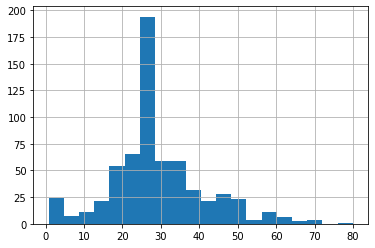

In [7]:
# histogram training ds
dftrain.age.hist(bins=20) 

male      410
female    217
Name: sex, dtype: int64


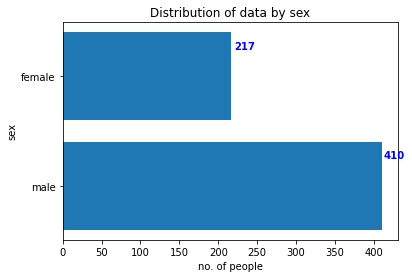

In [8]:
print(dftrain.sex.value_counts())

x = dftrain.sex.value_counts().index.tolist()
y = dftrain.sex.value_counts().values.tolist()

fig, ax = plt.subplots()    
ind = np.arange(len(x))  # the x locations for the groups

ax.barh(x, y)
ax.set_yticklabels(x)

plt.title('Distribution of data by sex')
plt.xlabel('no. of people')
plt.ylabel('sex')      
# plt.show()

for i, v in enumerate(y):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

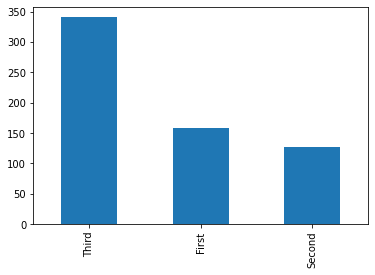

In [9]:
dftrain['class'].value_counts().plot(kind='bar')

Text(0.5, 0, '% survive')

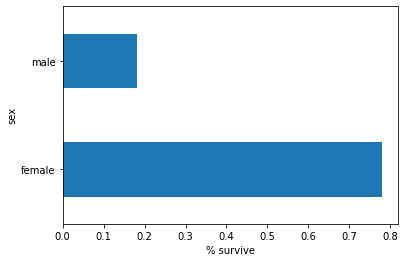

In [10]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

<p>Learnings ... </p>
Most passengers are in their 20's or 30's</br>
Most passengers are male</br>
Most passengers are in "Third" class</br>
Females have a much higher chance of survival</br>
Training data is what we feed to the model so that it can develop and learn.

<p>Testing data is what we use to evaulate the model and see how well it is performing.

# Categorize the data

Categorical data - non-numerical data that can be placed under a specified field

Note: Categorical data can be represented by numbers to identify the categories they belong to. (ex: Male = 1, Female = 0)

Numerical data - data that's represented by numbers

In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [12]:
dftrain['class'].unique() #.unique() gives all of the unique values withing the dataset (the names of the different data elements)

array(['Third', 'First', 'Second'], dtype=object)

In [13]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  #Create a column of feature names with the different associated vocabulary terms
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

# Training process

*   Models must be fed the data in batches
*   Batches are fed according to Epochs
  * Epochs are how many times the model will see the same data. Feeding the data to the model in variations Note: Over feeding the model can harm the outcome so feed it a little at a time.

Note: Over feeding the model can harm the outcome so feed it a little at a time.


# Input Function for Linear Regression
The TensorFlow model we are going to use requires that the data we pass it comes in as a `tf.data.Dataset` object. This means we must create a *input function* that can convert our current **pandas dataframe into that object**.

In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) #num_epochs is 1 because we aren't training this dataset like the line above. Shuffle is False because we don't need to shuffle since we are testing it. 


### Creating the Linear Regression Model

Here we will use a **linear estimator** utilize the linear regression algorithm.

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier through an estimator module

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model that tells the accuracy of it
#Accuracy - compares the dataset results with models predicted results to get the accuracy of the data

print(result)


0.7613636
{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.8374044, 'auc_precision_recall': 0.7848134, 'average_loss': 0.47222972, 'label/mean': 0.375, 'loss': 0.463149, 'precision': 0.6875, 'prediction/mean': 0.3635571, 'recall': 0.6666667, 'global_step': 200}


### Predicting the data set with the model

How to make predictions for every point in the evaluation data set

In [16]:
#Check the predictions of the model\n",
#Here we will turn the results into a list to get a dictionary of all points and predictions
result = list(linear_est.predict(eval_input_fn))
#print(result[0])
#Here are looking for the 'probabilities' dict because it will help us to see the probability that someone will survive or won't survive
#Look for this --> {'probabilities': array([0.9108078 (<--won't survive(0)) , 0.08919217 (<-- will survive(1))]}

#Here we will print the probability of survival (1)
print(result[0]['probabilities'][0]) #Format: [passenger/data point][data set dict][outcome (survival)]


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmybo0hfy/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9411231


To put this together we can evaluate the passengers' attributes to see if the prediction makes sense with the dfeval.loc[ ] method

In [17]:
print(dfeval.loc[36])
print(y_eval.loc[36])
print(result[36]['probabilities'][1])
#This will give us the passengers details and their chance of survival and if they survived"


sex                          male
age                          36.5
n_siblings_spouses              0
parch                           2
fare                         26.0
class                      Second
deck                            F
embark_town           Southampton
alone                           n
Name: 36, dtype: object
0
0.14018334
